In [1]:
from skimage.transform import resize
import numpy as np
import random
from skimage.filters import gaussian
from tqdm import tqdm
import matplotlib.cm as cm


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, ):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap_back =  heatmap
    heatmap = tf.maximum(heatmap, 0)
    cam_max = tf.math.reduce_max(heatmap)
    
    if cam_max != 0:
        heatmap = heatmap / cam_max
        
    if(np.percentile(heatmap, 99) == np.min(heatmap)):
        heatmap = (heatmap_back - np.min(heatmap_back)) / (np.max(heatmap_back) - np.min(heatmap_back))

    
    return heatmap.numpy()

In [2]:
#Importing Necessary Libraries.

from PIL import Image
import numpy as np
import pandas as pd 
import os
import re
import cv2
from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4024)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import lime
from lime import lime_image
from matplotlib import pylab as P

import saliency.core as saliency
import glob2

from datetime import datetime, timedelta
from RISE_tf.explain_image import RISE


tf.__version__

'2.5.0'

In [3]:
INPUT_DIR = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/EVAL_TESTE/XRAY_EVAL/"
OUTPUT_DIR = "./OUT/CUSTOM-XRAY-RANDOM/"
MODEL = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/1TRAIN_NEW_VGG_CUSTOM/CUSTOMCNN/X-RAY/CUSTOM-CNN-XRAY-RANDOM/basetuned_model.h5"
INPUT_FILES = glob2.glob(os.path.join(INPUT_DIR, "*/*.jpeg"))
EVAL_SIZE = len(INPUT_FILES)

In [4]:
def image_generator(directory, res, batch_size=1):
    test_datagen = ImageDataGenerator()
    image_generator = test_datagen.flow_from_directory(
            directory,
            target_size=(res, res),
            color_mode= 'rgb',
            batch_size= batch_size,  
            class_mode= 'categorical',
            shuffle= False, 
            seed= 1337)
    return image_generator

In [5]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [6]:
def save_greyscale(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    cv2.imwrite(str(Path(out_dir) / out_file),  cv2.cvtColor(mask*255,cv2.COLOR_GRAY2RGB))

def save_rgb(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    cv2.imwrite(str(Path(out_dir) / out_file), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
def save_heat(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    plt.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray', vmin = 0, vmax = 255)
    
def save_heat_image(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray')
    
def save_lime(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray', vmin= mask.min(), vmax=mask.max())
    
def save_blur(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap=P.cm.gray, vmin=0, vmax=1)
    
from matplotlib import pylab as P
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, file,  title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imsave(file, im, cmap=P.cm.gray, vmin=0, vmax=1)

def ShowHeatMap(im, file, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imsave(file, im, cmap='grey')
    
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img

def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def plot_single_img(img, ax=False, norm=diverging_norm, show_axis=False, grayscale=False, cmap='gray', title='', fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [7]:
conv_layer_str = "conv2d_2"

model_path = MODEL
m = tf.keras.models.load_model(model_path)
m.summary()
conv_layer = m.get_layer(conv_layer_str)
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

Found 50 images belonging to 2 classes.
1/1 [==============================] - 1s 715ms/step - loss: 5.3805 - accuracy: 0.4600
Test Loss:  5.380466938018799
Test Accuracy:  0.46000000834465027


<ipython-input-6-538294728fb7>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=fig_size)


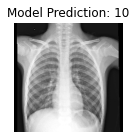

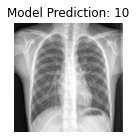

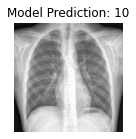

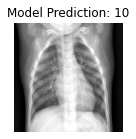

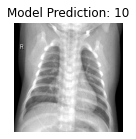

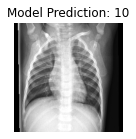

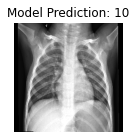

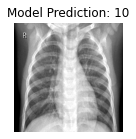

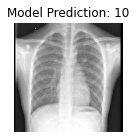

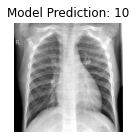

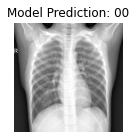

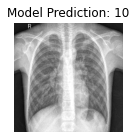

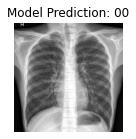

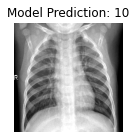

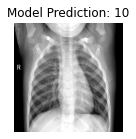

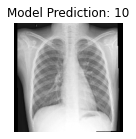

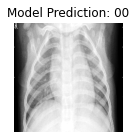

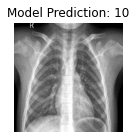

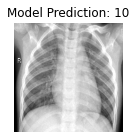

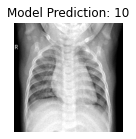

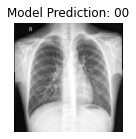

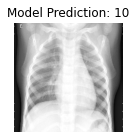

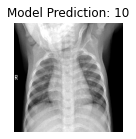

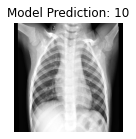

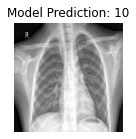

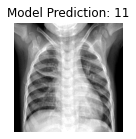

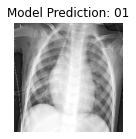

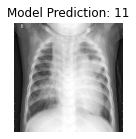

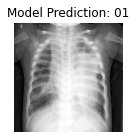

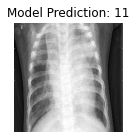

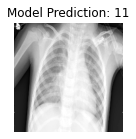

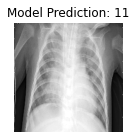

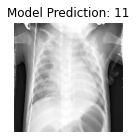

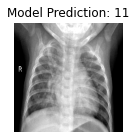

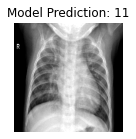

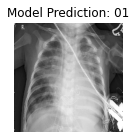

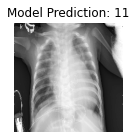

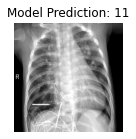

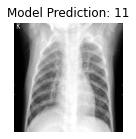

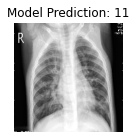

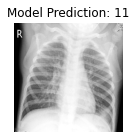

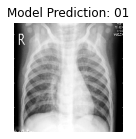

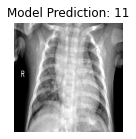

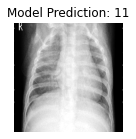

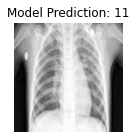

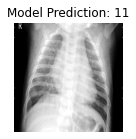

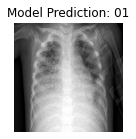

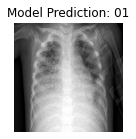

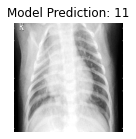

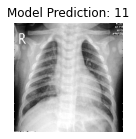

In [8]:
generator = image_generator(INPUT_DIR, 224, batch_size=EVAL_SIZE)
X, Y = generator.next()
logits = m.predict(X[:EVAL_SIZE])
predictions = logits.argmax(axis=1)

(eval_loss, eval_accuracy) = m.evaluate(generator, batch_size=EVAL_SIZE, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

for i in range(EVAL_SIZE):
    plot_single_img(X[i],
                    fig_size=(2,2),
                    title="Model Prediction: "+str(predictions[i]) +str(generator.classes[i]))

In [9]:
def vanilla_gradient(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    gradient_saliency = saliency.GradientSaliency()
    vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Vanilla Elapsed time:', timedelta(seconds=elapsed_seconds))
    return gradient_saliency, vanilla_mask_3d

def smooth_vanilla_gradient(im, call_model_function, call_model_args, gradient_saliency):
    start_time = datetime.now()
    
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args, stdev_spread=0.15,nsamples=50,magnitude=False)

    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Smooth Elapsed time:', timedelta(seconds=elapsed_seconds))
    return smoothgrad_mask_3d

def integrated_gradients_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    integrated_gradients = saliency.IntegratedGradients()
    baseline = np.zeros(im.shape)
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
      im, call_model_function, call_model_args, x_steps=50, x_baseline=baseline, batch_size=20)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('IG Elapsed time:', timedelta(seconds=elapsed_seconds))
    return integrated_gradients, vanilla_integrated_gradients_mask_3d

def guided_IGS_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    guided_ig = saliency.GuidedIG()
    baselineGuided = np.zeros(im.shape)
    guided_ig_mask_3d = guided_ig.GetMask(im, call_model_function, call_model_args, x_steps=50, x_baseline=baselineGuided, max_dist=1.0, fraction=0.5)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Guided Elapsed time:', timedelta(seconds=elapsed_seconds))
    return guided_ig_mask_3d

def blur_IG_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    blur_ig = saliency.BlurIG()
    blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Blur Elapsed time:', timedelta(seconds=elapsed_seconds))
    return blur_ig_mask_3d

def smooth_grad_func(im, call_model_function, call_model_args, integrated_gradients):
    start_time = datetime.now()
    
    baseline = np.zeros(im.shape)
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(im, call_model_function, call_model_args, x_steps=50, x_baseline=baseline, batch_size=20)

    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Smooth Elapsed time:', timedelta(seconds=elapsed_seconds))
    return smoothgrad_integrated_gradients_mask_3d

def grad_cam_func(img, m, conv_layer, prediction_class):
    start_time = datetime.now()
    gradcam = make_gradcam_heatmap(np.array([img]), m, conv_layer, pred_index=prediction_class)
    heatmap = np.uint8(255 * gradcam)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Grad Cam Elapsed time:', timedelta(seconds=elapsed_seconds))
    return jet_heatmap

def RISE_func(im, m, prediction_class):
    start_time = datetime.now()
    explainer = RISE()
    heatmaps, masks = explainer.explain(im, m)
    heatmap = heatmaps[prediction_class]
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Rise Elapsed time:', timedelta(seconds=elapsed_seconds))
    return heatmap

def XRAI_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    xrai_object = saliency.XRAI()
    xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('XRAI Elapsed time:', timedelta(seconds=elapsed_seconds))
    return xrai_attributions

def LIME_func(im, m, prediction_class):
    start_time = datetime.now()
    explainer = lime_image.LimeImageExplainer(verbose=True)
    explanation = explainer.explain_instance(im.astype('double'), m.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(prediction_class, positive_only=False, num_features=5, hide_rest=True)
    dict_heatmap = dict(explanation.local_exp[prediction_class])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('LIME Elapsed time:', timedelta(seconds=elapsed_seconds))
    return heatmap

In [10]:
def return_mask_dicts(im, im_org, call_model_function, call_model_args, prediction_class, m):

    output_masks_dict = {}
    
    #Original
    #output_masks_dict["Original"] = im_org

    # Vanilla Gradient mask.
    #gradient_saliency, vanilla_mask_3d = vanilla_gradient(im, call_model_function, call_model_args)
    #output_masks_dict["Gradient"] = vanilla_mask_3d
    
    # Smooth Gradient mask.
    #output_masks_dict["SmoothGrad"] = smooth_vanilla_gradient(im, call_model_function, call_model_args, gradient_saliency) 

    # Smooth Input-Grad.
    #output_masks_dict["Input-Grad"] = np.multiply(vanilla_mask_3d, im)

    #IntegratedGradients
    #integrated_gradients, vanilla_integrated_gradients_mask_3d = integrated_gradients_func(im, call_model_function, call_model_args)
    #output_masks_dict["IntegratedGradients"] = vanilla_integrated_gradients_mask_3d

    # Compute the Guided IG mask.
    #output_masks_dict["GuidedIG"] = guided_IGS_func(im, call_model_function, call_model_args)

    # Compute the vanilla mask and the Blur IG mask.
    #output_masks_dict["BlurIG"] = blur_IG_func(im, call_model_function, call_model_args)

    # Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
    #output_masks_dict["IGSmoothGrad"] = smooth_grad_func(im, call_model_function, call_model_args, integrated_gradients)

    #GradCAM
    output_masks_dict["GradCam"] = grad_cam_func(im, m, conv_layer_str, prediction_class)

    #RISE
    #output_masks_dict["RISE"] = RISE_func(im, m, prediction_class)

    # Compute XRAI attributions with default parameters
    #output_masks_dict["XRAI"] = XRAI_func(im, call_model_function, call_model_args)

    #LIME
    #output_masks_dict["LIME"] = LIME_func(im, m, prediction_class)

    return output_masks_dict

In [11]:
results = []
logits = predictions
for i in range(EVAL_SIZE):
    call_model_args = {class_idx_str: logits[i]}
    nome = generator.filenames[i]
    results = return_mask_dicts(X[i], X[i], call_model_function, call_model_args, logits[i], m)
    for k, v in results.items():
        if(k == "Original"):
            mask_abs_norm = v
            mask_no_abs_norm = v
            mask_0_1_norm = v
        mask_abs_norm = abs_grayscale_norm(v)
        mask_no_abs_norm = diverging_norm(v)
        mask_0_1_norm = normalize_image(v)
        
        path= nome.split("/")[1].split(".")[0]+".png"
        save_lime(Path(OUTPUT_DIR+k), path, mask_abs_norm)

Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:02
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:24
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.23998903939450483
Prediction_local [-0.03472465]
Right: 5.1630668e-08
Intercept 0.7600109487081365
Prediction_local [1.03472466]
Right: 1.0
LIME Elapsed time: 0:00:17
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:24
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5780684679206652
Prediction_local [0.03569456]
Right: 0.00062947447
Intercept 0.4219315380570053
Prediction_local [0.96430544]
Right: 0.9993705
LIME Elapsed time: 0:00:17
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.17479021014265134
Prediction_local [0.09870859]
Right: 0.00076034054
Intercept 0.8252097789360918
Prediction_local [0.90129142]
Right: 0.9992397
LIME Elapsed time: 0:00:17
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:02
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.31360654915932673
Prediction_local [0.20905533]
Right: 0.08365533
Intercept 0.6863934518619553
Prediction_local [0.79094467]
Right: 0.9163447
LIME Elapsed time: 0:00:17
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:02
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.12373051700066977
Prediction_local [-0.02474111]
Right: 2.8590395e-07
Intercept 0.8762694722673837
Prediction_local [1.02474112]
Right: 0.99999976
LIME Elapsed time: 0:00:18
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.20415513114560566
Prediction_local [-0.12309163]
Right: 5.080381e-13
Intercept 0.795844862836721
Prediction_local [1.12309163]
Right: 1.0
LIME Elapsed time: 0:00:18
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:13
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5357188246889852
Prediction_local [-0.19520337]
Right: 2.8062274e-08
Intercept 0.4642811702756899
Prediction_local [1.19520338]
Right: 1.0
LIME Elapsed time: 0:00:17
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.166821916026477
Prediction_local [0.01101637]
Right: 0.0025675239
Intercept 0.8331780840087027
Prediction_local [0.98898363]
Right: 0.99743253
LIME Elapsed time: 0:00:18
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:09
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:16


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.6321879649219457
Prediction_local [0.04857159]
Right: 0.013473389
Intercept 0.36781204286629804
Prediction_local [0.9514284]
Right: 0.98652655
LIME Elapsed time: 0:00:18
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:24
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.05899965849943531
Prediction_local [0.00177576]
Right: 7.541043e-07
Intercept 0.9410003377951109
Prediction_local [0.99822425]
Right: 0.9999993
LIME Elapsed time: 0:00:17
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5707941556227464
Prediction_local [0.54236852]
Right: 0.3990733
Intercept 0.42920583838265164
Prediction_local [0.45763148]
Right: 0.60092676
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:09
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:24
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4807510172657372
Prediction_local [-0.00724325]
Right: 1.8352022e-08
Intercept 0.5192489822714431
Prediction_local [1.00724325]
Right: 1.0
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:09
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:09
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.009564120423411
Prediction_local [0.49743846]
Right: 9.836208e-06
Intercept -0.009564109220666778
Prediction_local [0.50256154]
Right: 0.9999901
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:09
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:09
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2794250302066722
Prediction_local [0.01496658]
Right: 0.06189633
Intercept 0.7205749903599544
Prediction_local [0.98503341]
Right: 0.9381036
LIME Elapsed time: 0:00:13
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:05
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:13
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.15580064794119913
Prediction_local [-0.0815137]
Right: 5.0218564e-06
Intercept 0.844199345032473
Prediction_local [1.08151371]
Right: 0.999995
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:14
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5419867598435057
Prediction_local [-0.13330156]
Right: 1.9753944e-13
Intercept 0.4580132427564369
Prediction_local [1.13330156]
Right: 1.0
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:09
Blur Elapsed time: 0:00:15
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.8040392192274033
Prediction_local [0.73261288]
Right: 0.17742921
Intercept 0.19596077848401108
Prediction_local [0.26738712]
Right: 0.8225708
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:15
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.26856460987469505
Prediction_local [0.07079617]
Right: 1.126433e-09
Intercept 0.7314353984827507
Prediction_local [0.92920382]
Right: 1.0
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:15
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1353003506455182
Prediction_local [0.11476087]
Right: 0.021890515
Intercept 0.8646996456137718
Prediction_local [0.88523913]
Right: 0.9781095
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:15
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:24
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1589799391495308
Prediction_local [0.20233074]
Right: 0.44311565
Intercept 0.8410200580777049
Prediction_local [0.79766926]
Right: 0.5568844
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:13
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:26
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.9099464926418591
Prediction_local [0.83918427]
Right: 0.062183157
Intercept 0.09005350007537824
Prediction_local [0.16081574]
Right: 0.9378168
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:13
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:26
XRAI Elapsed time: 0:00:16


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1438314664095819
Prediction_local [0.07999755]
Right: 1.9532497e-05
Intercept 0.8561685391355265
Prediction_local [0.92000245]
Right: 0.99998045
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:27
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3488572910462825
Prediction_local [-0.13169001]
Right: 1.3158341e-06
Intercept 0.651142703983847
Prediction_local [1.13169001]
Right: 0.9999987
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:28
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.1231981732682041
Prediction_local [0.16073993]
Right: 0.0056835893
Intercept -0.12319817638913272
Prediction_local [0.83926007]
Right: 0.9943164
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:28
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2893487076618197
Prediction_local [-0.10910347]
Right: 0.0033771403
Intercept 0.7106512943462239
Prediction_local [1.10910347]
Right: 0.9966228
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:28
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.07639648968510383
Prediction_local [0.1045433]
Right: 0.011742067
Intercept 0.9236035053027503
Prediction_local [0.89545671]
Right: 0.98825794
LIME Elapsed time: 0:00:16
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:28
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.9613026775281464
Prediction_local [0.64698039]
Right: 0.011908692
Intercept 0.038697311033483034
Prediction_local [0.35301962]
Right: 0.98809135
LIME Elapsed time: 0:00:16
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:26
XRAI Elapsed time: 0:00:20


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.12064249330230303
Prediction_local [0.1475132]
Right: 0.0005928577
Intercept 0.8793575075024281
Prediction_local [0.85248681]
Right: 0.9994072
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:26
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.7899367997141834
Prediction_local [0.6286774]
Right: 0.049172863
Intercept 0.21006319497423842
Prediction_local [0.3713226]
Right: 0.9508272
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:29
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.7732478736252066
Prediction_local [0.03788484]
Right: 0.016109614
Intercept 0.22675213410150719
Prediction_local [0.96211515]
Right: 0.98389035
LIME Elapsed time: 0:00:16
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:27
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.8358239201615697
Prediction_local [0.15008135]
Right: 1.1685741e-08
Intercept 0.16417608494499059
Prediction_local [0.84991864]
Right: 1.0
LIME Elapsed time: 0:00:16
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:27
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.32501405483031776
Prediction_local [0.33282941]
Right: 0.47518164
Intercept 0.6749859700774808
Prediction_local [0.66717056]
Right: 0.5248183
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:27
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4640055973081465
Prediction_local [-0.04460456]
Right: 1.5535704e-06
Intercept 0.5359944119147171
Prediction_local [1.04460455]
Right: 0.99999845
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:28
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.254696212422138
Prediction_local [-0.09559225]
Right: 2.847647e-16
Intercept 0.7453037827273592
Prediction_local [1.09559226]
Right: 1.0
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:27
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1411352542838705
Prediction_local [-0.06654153]
Right: 0.072759375
Intercept 0.8588647383045886
Prediction_local [1.06654154]
Right: 0.92724067
LIME Elapsed time: 0:00:16
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:26
XRAI Elapsed time: 0:00:20


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.8693223507304515
Prediction_local [0.71169558]
Right: 0.35681328
Intercept 0.13067765720518565
Prediction_local [0.28830441]
Right: 0.6431867
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:27
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.17751044316622905
Prediction_local [0.31132423]
Right: 0.45286706
Intercept 0.8224895527395206
Prediction_local [0.68867577]
Right: 0.54713297
LIME Elapsed time: 0:00:16
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:28
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2190342197919211
Prediction_local [-0.08755881]
Right: 2.864758e-05
Intercept 0.7809657703743325
Prediction_local [1.08755882]
Right: 0.9999714
LIME Elapsed time: 0:00:16
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:08
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:08
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:28
XRAI Elapsed time: 0:00:17


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.19283901032029394
Prediction_local [-0.04719117]
Right: 1.9082752e-12
Intercept 0.807160988990996
Prediction_local [1.04719117]
Right: 1.0
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:28
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2829033976781659
Prediction_local [-0.07163297]
Right: 9.58456e-10
Intercept 0.717096599521915
Prediction_local [1.07163298]
Right: 1.0
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:27
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1080338360262029
Prediction_local [0.03982425]
Right: 6.3637122e-09
Intercept 0.8919661705107599
Prediction_local [0.96017575]
Right: 1.0
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:27
XRAI Elapsed time: 0:00:19


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.1266051878518155
Prediction_local [0.5718941]
Right: 3.308333e-07
Intercept -0.1266051835403529
Prediction_local [0.42810589]
Right: 0.99999964
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:25
XRAI Elapsed time: 0:00:20


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.950962799306093
Prediction_local [-0.18252988]
Right: 1.2691759e-10
Intercept 0.049037201834869926
Prediction_local [1.18252988]
Right: 1.0
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:25
XRAI Elapsed time: 0:00:20


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.04442642207341713
Prediction_local [0.01187696]
Right: 5.464303e-11
Intercept 0.9555735772139877
Prediction_local [0.98812304]
Right: 1.0
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:11
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:24
XRAI Elapsed time: 0:00:21


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 1.0345950836169315
Prediction_local [0.57397368]
Right: 0.12679912
Intercept -0.03459509928094534
Prediction_local [0.42602634]
Right: 0.8732009
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:24
XRAI Elapsed time: 0:00:20


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.13393921227500372
Prediction_local [0.29121428]
Right: 0.010114817
Intercept 0.8660607865273187
Prediction_local [0.70878573]
Right: 0.9898852
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:06
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:24
XRAI Elapsed time: 0:00:20


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5373371715076253
Prediction_local [0.82427602]
Right: 0.39079672
Intercept 0.46266283133639435
Prediction_local [0.17572398]
Right: 0.6092032
LIME Elapsed time: 0:00:14
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:22
XRAI Elapsed time: 0:00:21


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5848358711940345
Prediction_local [0.78910889]
Right: 0.39079672
Intercept 0.4151641550183275
Prediction_local [0.21089108]
Right: 0.6092032
LIME Elapsed time: 0:00:15
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:07
IG Elapsed time: 0:00:04
Guided Elapsed time: 0:00:07
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:23
XRAI Elapsed time: 0:00:20


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1671167891060587
Prediction_local [0.06032826]
Right: 0.00016457605
Intercept 0.8328832245384042
Prediction_local [0.93967173]
Right: 0.9998354
LIME Elapsed time: 0:00:16
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:05
IG Elapsed time: 0:00:03
Guided Elapsed time: 0:00:06
Blur Elapsed time: 0:00:12
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:00:22
XRAI Elapsed time: 0:00:18


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3610634943601815
Prediction_local [-0.02727753]
Right: 4.760161e-08
Intercept 0.6389365044347458
Prediction_local [1.02727754]
Right: 1.0
LIME Elapsed time: 0:00:17
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
